## Import Initial Libraries and Settings


In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from IPython.core.display import Image, display
import matplotlib.pyplot as plt

## Reading Data 


In [2]:
import pandas as pd 
import numpy as np
import csv


pokemon = pd.read_csv("pokemon.csv")


## Data Preperation for Classification

In [3]:
# Cleaning and imputing missing values
pokemon.drop(['Generation'],inplace=True,axis=1)
pokemon.rename(columns={'#':'id'},inplace=True)
#filling NA with None
pokemon['Type 2'] = pokemon['Type 2'].fillna('None')
#Checking info of the dataset
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
id           800 non-null int64
Name         799 non-null object
Type 1       800 non-null object
Type 2       800 non-null object
HP           800 non-null int64
Attack       800 non-null int64
Defense      800 non-null int64
Sp. Atk      800 non-null int64
Sp. Def      800 non-null int64
Speed        800 non-null int64
Legendary    800 non-null bool
dtypes: bool(1), int64(7), object(3)
memory usage: 63.4+ KB


In [4]:
#We can see there is 1 name missing from the dataset
#After searching the internet,found out that the Name is Primape
#replacing the NAN with Primape

pokemon['Name'] = pokemon['Name'].fillna('Primeape')

#some type is named 'Fight', and some named 'Fighting'. This code is to clean it up.
pokemon['Type 1'] = pokemon['Type 1'].replace('Fighting', 'Fight')
pokemon['Type 2'] = pokemon['Type 2'].replace('Fighting', 'Fight')


pokemon_df = pokemon.copy()

#final Pokemon Dataset
pokemon.head()



,id,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,None,39,52,43,60,50,65,False


In [5]:
# Drop three columns we don't use
pokemon.drop(["id"],inplace=True,axis=1)
pokemon.drop(["Type 2"],inplace=True,axis=1)
pokemon.head()

,Name,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,Bulbasaur,Grass,45,49,49,65,65,45,False
1,Ivysaur,Grass,60,62,63,80,80,60,False
2,Venusaur,Grass,80,82,83,100,100,80,False
3,Mega Venusaur,Grass,80,100,123,122,120,80,False
4,Charmander,Fire,39,52,43,60,50,65,False


In [6]:
# Add one column named "Total"
pokemon['Total']= pokemon['HP']+pokemon['Attack']+pokemon['Defense']+pokemon['Sp. Atk']+pokemon['Sp. Def']+pokemon['Speed']
pokemon.head()

,Name,Type 1,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Total
0,Bulbasaur,Grass,45,49,49,65,65,45,False,318
1,Ivysaur,Grass,60,62,63,80,80,60,False,405
2,Venusaur,Grass,80,82,83,100,100,80,False,525
3,Mega Venusaur,Grass,80,100,123,122,120,80,False,625
4,Charmander,Fire,39,52,43,60,50,65,False,309


## Exploratory Data Analysis

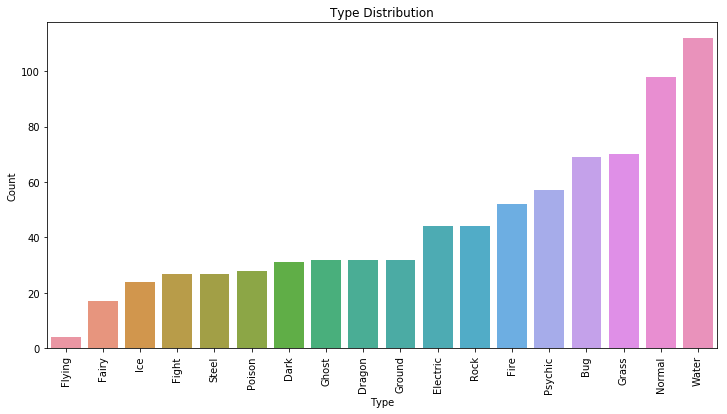

In [7]:
# Draw the Type distribution - Bar Chat
pokemon1 = pokemon.groupby('Type 1')['Type 1'].count().reset_index(name = 'Count')
pokemon1 = pokemon1.sort_values(by = 'Count') #sort type by count
# plots is shown below
plt.figure(figsize=(12,6))
sns.barplot(x=pokemon1['Type 1'], y= pokemon1['Count'])
plt.xticks(rotation= 90)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Type Distribution')
plt.show()

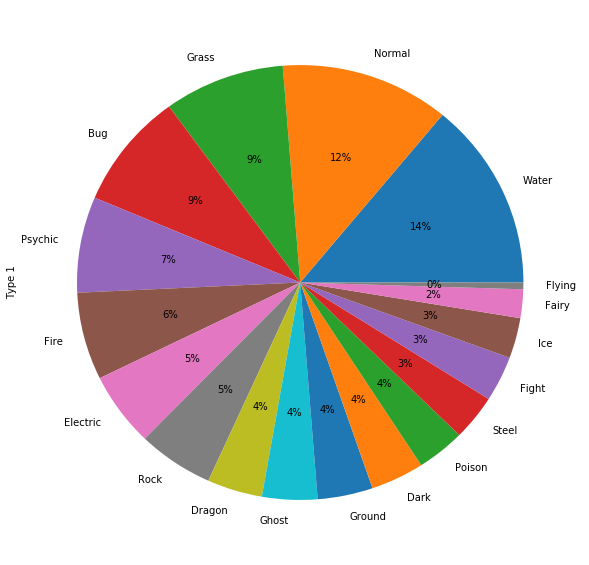

In [8]:
# Lets view the proportion by %'s instead
plt.figure(figsize=(10,10))
labels = pokemon['Type 1'].value_counts().index
pokemon['Type 1'].value_counts().plot(kind='pie', labels=labels, autopct='%1.0f%%')
plt.show()

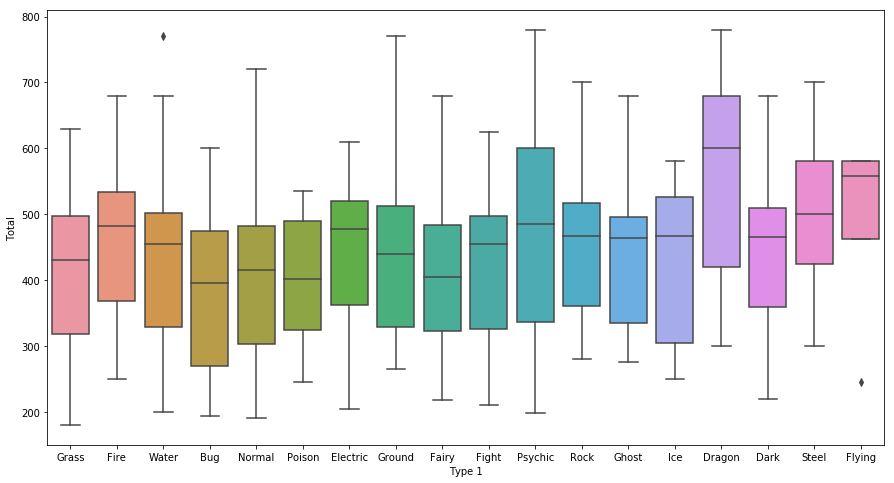

In [9]:
# draw the boxplot of total based on different types
plt.figure(figsize=(15,8))
ax = sns.boxplot(x = 'Type 1', y = 'Total', data = pokemon )
plt.show()

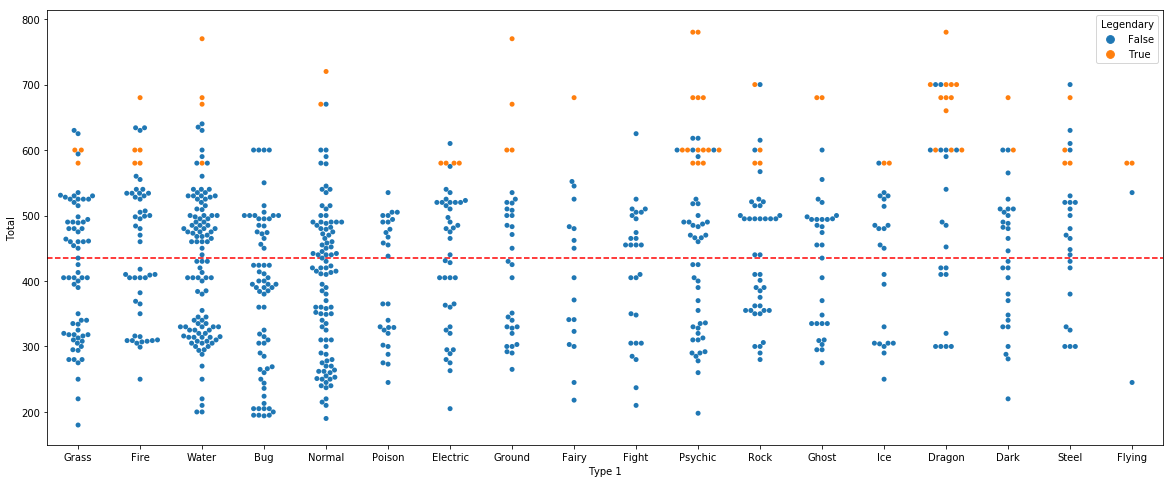

In [10]:
# compare the legendaries total features with non-legendary ones
plt.figure(figsize=(20,8))
sns.swarmplot(x='Type 1', y='Total', data=pokemon, hue='Legendary')
plt.axhline(pokemon['Total'].mean(), color='red', linestyle='dashed')
plt.show()

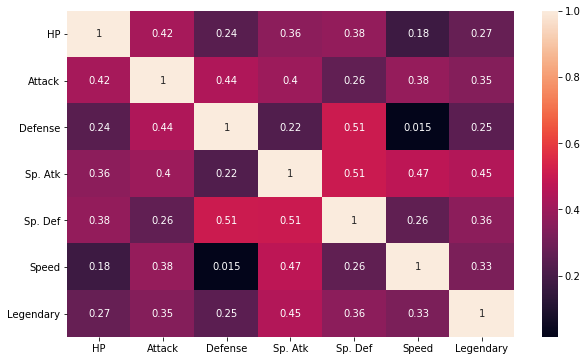

In [11]:

# Correlation
pokemon.drop(["Total"],inplace=True,axis=1)
plt.figure(figsize=(10,6)) #manage the size of the plot
sns.heatmap(pokemon.corr(),annot=True) #df.corr() makes a correlation matrix and sns.heatmap is used to show the correlations heatmap
plt.show()

In [12]:
# Set legendary False = 0, True = 1
pokemon['Legendary'] = np.where(pokemon['Legendary'] == True, 1, 0)


## Preparing our Model

In [13]:
# Remove out a random sample of 5% of EACH TYPE of pokemon to be used as the test data
type_list = list(pokemon['Type 1'].unique())

pokemon_test = pd.DataFrame(columns = pokemon.columns)
for i in type_list:
    pokemon_test = pokemon_test.append((pokemon[pokemon['Type 1'] == i]).sample(frac=0.05))

In [14]:
# Now remove the sample rows from the main dataset
pokemon_train = pokemon[~pokemon['Name'].isin(pokemon_test['Name'])]

In [15]:
# Standardize and scale our numeric data
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()

X_train = max_abs_scaler.fit_transform(pokemon_train.iloc[:,2:8])
X_test = max_abs_scaler.fit_transform(pokemon_test.iloc[:,2:8])

In [16]:
# Create an arrays for our labels
array_train = pokemon_train.values
array_test = pokemon_test.values

Y_train = array_train[:,1]
Y_test = array_test[:,1]

In [17]:
# Import Naives Bayes and 10-fold cross validation
from sklearn import model_selection

# Prepare the kfold model
kfold = model_selection.KFold(n_splits=10, shuffle=True)

# Leave one out cross validation model
loocv = model_selection.LeaveOneOut()

In [18]:
# Train the Naive Bayes model
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB(priors=None)

In [19]:
# Naives Bayes with Kfolds on our Test Data
results = model_selection.cross_val_score(gnb, X_test, Y_test, cv=kfold)
results.mean()

0.025000000000000001

In [20]:
# Naive Bayes with LOOCV on our Test Data
results2 = model_selection.cross_val_score(gnb, X_test, Y_test, cv=loocv)
results2.mean()

0.024390243902439025

In [21]:
# Import SVM
from sklearn.svm import SVC
from sklearn import svm
estimator = SVC(kernel='linear')

# Let us conduct parameter tuning with GridSearchCV to optimize our results
from sklearn.model_selection import GridSearchCV

In [22]:
# Prep up parameters to tune
svm_parameters = [
                  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
                  ]

In [23]:
# Train our SVM classifier                  
svm_classifier = GridSearchCV(estimator=estimator, cv=kfold, param_grid=svm_parameters)
svm_classifier.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
# The best parameters with the score:
print('Best score for data:', svm_classifier.best_score_)
print('Best C:',svm_classifier.best_estimator_.C) 
print('Best Kernel:',svm_classifier.best_estimator_.kernel)
print('Best Gamma:',svm_classifier.best_estimator_.gamma)

Best score for data: 0.242424242424
Best C: 1000
Best Kernel: linear
Best Gamma: auto


In [25]:
svm_classifier.estimator #estimator svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# Test our trained SVM classifier with our test data
svm_classifier.score(X_test, Y_test)

0.17073170731707318

In [27]:
#start random forest
from sklearn.ensemble import RandomForestClassifier

In [28]:
#forest_clf = RandomForestClassifier()
forest_clf = RandomForestClassifier(random_state=0)
forest_clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
# train score
print('Best score for data:',np.mean(forest_clf.feature_importances_))

Best score for data: 0.166666666667


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
forest_clf.score(X_test, Y_test) # test socre
#Random Forest Result 

0.14634146341463414

In [31]:
#KNN classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [32]:
knn = KNeighborsClassifier(n_neighbors = 3)
x1 = pokemon.loc[:,['HP','Attack','Defense','Speed','Sp. Atk','Sp. Def']]
y1 = pokemon.loc[:,'Type 1']
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size = 0.3)
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)

In [33]:
print('With KNN (K=) accuracy is: ',knn.score(x_test,y_test)) 
#KNN Result

With KNN (K=) accuracy is:  0.1875


## Predicting the Winner of the Combats


## Loading datasets for Winner Prediction

In [35]:
tests = pd.read_csv("tests.csv")
combats = pd.read_csv("combats.csv")

## Data Preperation

In [36]:
#Changing the Winner with 0 and 1
#if winner is first Pokemon then Winner is 0 else 1
combats.Winner[combats.Winner == combats.First_pokemon] = 0
combats.Winner[combats.Winner == combats.Second_pokemon] = 1

print(combats.head(5))

   First_pokemon  Second_pokemon  Winner
0            266             298       1
1            702             701       1
2            191             668       1
3            237             683       1
4            151             231       0


In [37]:
#creating Dictonaries for type and stats
#Type Dict will have type 1 and type 2 while stats will have the rest of the stats data

type_dic = pokemon_df.iloc[:,0:4]
type_dic=type_dic.drop("Name", axis=1)
type_dic.head()
stats_dic = pokemon_df.drop(['Name','Type 1','Type 2'],axis=1)

type_dict = type_dic.set_index('id').T.to_dict('list')
stats_dict = stats_dic.set_index('id').T.to_dict('list')

## Data Engineering

In [38]:
#creating a replace function that will map the type and stats of first and second pokemon in their respective Dictionaries
def replace(data):
    data['First_pokemon_stats'] = data.First_pokemon.map(stats_dict)
    data['Second_pokemon_stats']= data.Second_pokemon.map(stats_dict)
    
    data['First_pokemon'] = data.First_pokemon.map(type_dict)
    data['Second_pokemon'] = data.Second_pokemon.map(type_dict)
    
    
    return data

In [39]:
#stats_diff function will get the difference in stats of the first and the second pokemon and give us a dataframe consisting of those differences
#taking the differnce would reduce the features while taking into account their effectiveness on the dataset
def stats_diff(data):
        stats_col=["HP_diff","Attack_diff","Defense_diff",'Sp.Atk_diff', 'Sp.Def_diff', 'Speed_diff', 'Legendary_diff']
        diff_list=[]
    
        for row in data.itertuples():
            diff_list.append(np.array(row.First_pokemon_stats) - np.array(row.Second_pokemon_stats))
        
        
        stats_df = pd.DataFrame(diff_list, columns=stats_col)
        data = pd.concat([data, stats_df], axis=1)
        data.drop(['First_pokemon_stats', 'Second_pokemon_stats'], axis=1, inplace=True)
        
        return data

In [40]:
# Dictionaries having effectiveness of different types of pokemon on each other.
#created 4 lists based on the types and their effectiveness on each other 
# the values in the lists starts with 1, if type is found in the very_effective dictionary then the value is multiplied by 2
#if value found in not_very_effective then value is divided by 2

def effectiveness(data):
    
    
    very_effective_dict = {'Normal': [],
                           'Fight': ['Normal', 'Rock', 'Steel', 'Ice', 'Dark'],
                           'Flying': ['Fight', 'Bug', 'Grass'],
                           'Poison': ['Grass', 'Fairy'],
                           'Ground': ['Poison', 'Rock', 'Steel', 'Fire', 'Electric'],
                           'Rock': ['Flying', 'Bug', 'Fire', 'Ice'],
                           'Bug': ['Grass', 'Psychic', 'Dark'],
                           'Ghost': ['Ghost', 'Psychic'],
                           'Steel': ['Rock', 'Ice', 'Fairy'],
                           'Fire': ['Bug', 'Steel', 'Grass', 'Ice'],
                           'Water': ['Ground', 'Rock', 'Fire'],
                           'Grass': ['Ground', 'Rock', 'Water'],
                           'Electric': ['Flying', 'Water'],
                           'Psychic': ['Fight', 'Poison'],
                           'Ice': ['Flying', 'Ground', 'Grass', 'Dragon'],
                           'Dragon': ['Dragon'],
                           'Dark': ['Ghost', 'Psychic'],
                           'Fairy': ['Fight', 'Dragon', 'Dark'],
                           'None': []}
    not_very_effective_dict = {'Normal': ['Rock', 'Steel'],
                               'Fight': ['Flying', 'Poison', 'Bug', 'Psychic', 'Fairy'],
                               'Flying': ['Rock', 'Steel', 'Electric'],
                               'Poison': ['Poison', 'Rock', 'Ground', 'Ghost'],
                               'Ground': ['Bug', 'Grass'],
                               'Rock': ['Fight', 'Ground', 'Steel'],
                               'Bug': ['Fight', 'Flying', 'Poison', 'Ghost', 'Steel', 'Fire', 'Fairy'],
                               'Ghost': ['Dark'],
                               'Steel': ['Steel', 'Fire', 'Water', 'Electric'],
                               'Fire': ['Rock', 'Fire', 'Water', 'Dragon'],
                               'Water': ['Water', 'Grass', 'Dragon'],
                               'Grass': ['Flying', 'Poison', 'Bug', 'Steel', 'Fire', 'Grass', 'Dragon'],
                               'Electric': ['Grass', 'Electric', 'Dragon'],
                               'Psychic': ['Steel', 'Psychic'],
                               'Ice': ['Steel', 'Fire', 'Water', 'Psychic'],
                               'Dragon': ['Steel'],
                               'Dark': ['Fight', 'Dark', 'Fairy'],
                               'Fairy': ['Posion', 'Steel', 'Fire'],
                               'None': []}

    
    p1_type1=[]
    p1_type2=[]
    p2_type1=[]
    p2_type2=[]
    
    
    for row in data.itertuples():
        nested_type =[[1,1], [1,1]]
        for i in range (0,2):
            for j in range (0,2):
                if row.Second_pokemon[j] in very_effective_dict.get(row.First_pokemon[i]):
                    nested_type[0][i] *=2
                if row.Second_pokemon[j] in not_very_effective_dict.get(row.First_pokemon[i]):
                    nested_type[0][i] /=2
                
                if row.First_pokemon[j] in very_effective_dict.get(row.Second_pokemon[i]):
                    nested_type[1][i] *=2
                if row.First_pokemon[j] in not_very_effective_dict.get(row.Second_pokemon[i]):
                    nested_type[1][i] /=2
                
                
        p1_type1.append(nested_type[0][0])
        p1_type2.append(nested_type[0][1])
        p2_type1.append(nested_type[1][0])
        p2_type2.append(nested_type[1][1])
        
        
    data = data.assign(P1_Type1=p1_type1,P1_Type2=p1_type2,P2_Type1=p2_type1,P2_Type2=p2_type2)
        
    data = data.drop(['First_pokemon', 'Second_pokemon'], axis=1)

    return data

In [41]:
#training the dataset
train_df = replace(combats)
print(train_df.head(5))

     First_pokemon   Second_pokemon  Winner  \
0   [Rock, Ground]    [Grass, Dark]       1   
1   [Grass, Fight]    [Rock, Fight]       1   
2  [Fairy, Flying]  [Psychic, None]       1   
3     [Fire, None]   [Dragon, None]       1   
4    [Rock, Water]      [Bug, Rock]       0   

                 First_pokemon_stats              Second_pokemon_stats  
0    [50, 64, 50, 45, 50, 41, False]   [70, 70, 40, 60, 40, 60, False]  
1   [91, 90, 72, 90, 129, 108, True]  [91, 129, 90, 72, 90, 108, True]  
2   [55, 40, 85, 80, 105, 40, False]  [75, 75, 75, 125, 95, 40, False]  
3    [40, 40, 40, 70, 40, 20, False]  [77, 120, 90, 60, 90, 48, False]  
4  [70, 60, 125, 115, 70, 55, False]  [20, 10, 230, 10, 230, 5, False]  


In [42]:
# called the stats_diff function that gives us the difference
train_df = stats_diff(train_df)
print(train_df.head(5))

     First_pokemon   Second_pokemon  Winner  HP_diff  Attack_diff  \
0   [Rock, Ground]    [Grass, Dark]       1      -20           -6   
1   [Grass, Fight]    [Rock, Fight]       1        0          -39   
2  [Fairy, Flying]  [Psychic, None]       1      -20          -35   
3     [Fire, None]   [Dragon, None]       1      -37          -80   
4    [Rock, Water]      [Bug, Rock]       0       50           50   

   Defense_diff  Sp.Atk_diff  Sp.Def_diff  Speed_diff  Legendary_diff  
0            10          -15           10         -19               0  
1           -18           18           39           0               0  
2            10          -45           10           0               0  
3           -50           10          -50         -28               0  
4          -105          105         -160          50               0  


In [43]:
#called effectiveness function 
train_df = effectiveness(train_df)
print(train_df.head(5))

   Winner  HP_diff  Attack_diff  Defense_diff  Sp.Atk_diff  Sp.Def_diff  \
0       1      -20           -6            10          -15           10   
1       1        0          -39           -18           18           39   
2       1      -20          -35            10          -45           10   
3       1      -37          -80           -50           10          -50   
4       0       50           50          -105          105         -160   

   Speed_diff  Legendary_diff  P1_Type1  P1_Type2  P2_Type1  P2_Type2  
0         -19               0       1.0       0.5       4.0       1.0  
1           0               0       2.0       2.0       0.5       1.0  
2           0               0       1.0       1.0       1.0       1.0  
3         -28               0       0.5       1.0       1.0       1.0  
4          50               0       2.0       2.0       1.0       1.0  


In [44]:
#Did test train split 
from sklearn.model_selection import train_test_split

y_train_full = train_df['Winner']
x_train_full = train_df.drop('Winner', axis=1)

from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=42)

## Creating Models to Predict 
Model would be selected based on the accuracy of the model

In [45]:
# Creating the Modelling and predicting the winner
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

clf_dict = {'log reg': LogisticRegression(), 
            'naive bayes': GaussianNB(), 
            'random forest': RandomForestClassifier(n_estimators=100),
            'knn': KNeighborsClassifier(),
            'gradient boosting': GradientBoostingClassifier(n_estimators=100),
            'Decision Tree': DecisionTreeClassifier()}

for name, clf in clf_dict.items():
    model = clf.fit(x_train, y_train)
    pred = model.predict(x_cv)
    print('Accuracy of {}:'.format(name), accuracy_score(pred, y_cv))

Accuracy of log reg: 0.88344
Accuracy of naive bayes: 0.80776
Accuracy of random forest: 0.95184
Accuracy of knn: 0.90376
Accuracy of gradient boosting: 0.94848
Accuracy of Decision Tree: 0.91552


## Predicting the Winner

In [46]:
#Found that Random forest fits well and used it to predict the tests dataset
prediction_df = tests.copy()
test_df = replace(tests)
test_df = stats_diff(test_df)
test_df = effectiveness(test_df)
print(test_df.head())

classifier = RandomForestClassifier(n_estimators=100)
model = classifier.fit(x_train_full, y_train_full)
prediction = model.predict(test_df)

#prediction_df is created at the very beginning, it's the same thing as test_df before it's changed.
prediction_df['Winner'] = prediction
prediction_df['Winner'][prediction_df['Winner'] == 0] = prediction_df['First_pokemon']
prediction_df['Winner'][prediction_df['Winner'] == 1] = prediction_df['Second_pokemon']
print(prediction_df)

   HP_diff  Attack_diff  Defense_diff  Sp.Atk_diff  Sp.Def_diff  Speed_diff  \
0      -10           37           -10            5            5          38   
1      -21            9            46          -11           51         -15   
2       29          -15            17          110          -30          14   
3       -5          -31           -12          -26           -7         -15   
4     -125          -15           -50           -9          -14           5   

   Legendary_diff  P1_Type1  P1_Type2  P2_Type1  P2_Type2  
0               0       1.0       1.0       1.0       1.0  
1               0       4.0       0.5       0.5       1.0  
2               1       1.0       2.0       0.5       1.0  
3               0       0.5       1.0       1.0       1.0  
4               0       1.0       1.0       1.0       1.0  
      First_pokemon  Second_pokemon  Winner
0               129             117     129
1               660             211     211
2               706             1